# Learning
Nothing too interesting going on in here. We solve a linear regression problem using gradient descent, first implemented manually using finite differences, then using PyTorch's *Autograd* and *optimizer*s.

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

## Data
Two datasets, `t_c` should be predicted from `t_u`.

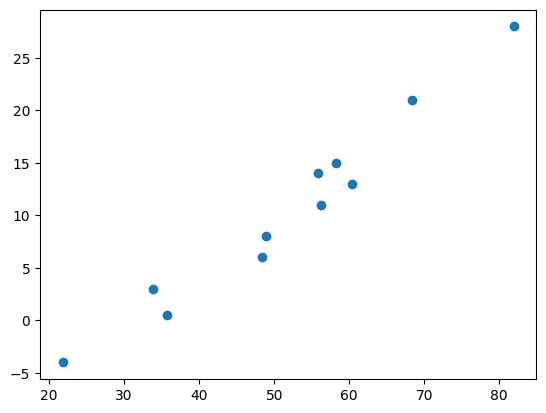

In [89]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

plt.scatter(t_u.numpy(), t_c.numpy())
plt.show()

## Model
A linear model with the two skalar parameters inclination `w` and intercept `b`.

In [90]:
def model(x: torch.Tensor, w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return w * x + b;

## Loss Function
Mean squared error..

In [91]:
def loss_fn(y_pred: torch.Tensor, y_truth: torch.Tensor) -> torch.Tensor:
    return ((y_pred - y_truth) ** 2).mean()

## Initialize Parameters

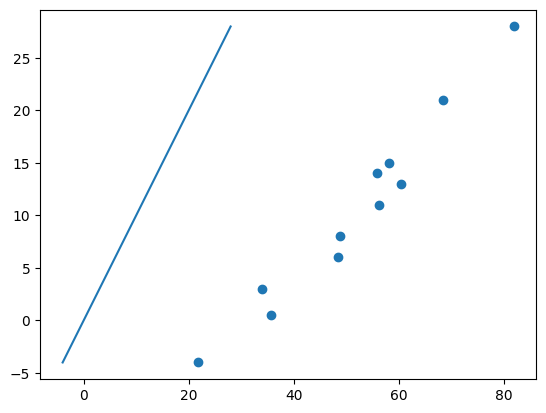

In [92]:
w = torch.ones(())
b = torch.zeros(())

# show initial model next to data
x_ = np.linspace(float(t_c.min()), float(t_c.max()), 100)
y_ = model(x_, w, b).numpy()
plt.scatter(t_u, t_c)
plt.plot(x_, y_)

Initial Loss

In [93]:
loss_fn(y_pred = model(t_u, w, b),
        y_truth = t_c)

tensor(1763.8848)

## Finite Differences

In [ ]:
def grad(f, x, delta = 0.1):
    """Return the finite difference of `f` at `x` using the supplied `delta`."""
    return (f(x + delta) - f(x - delta)) / (2.0 * delta)

Finite Differences at `w` and `b`

In [95]:
loss_fn_grad_w = grad(lambda w : loss_fn(y_pred  = model(t_u, w, b),
                                         y_truth = t_c),
                      w)
loss_fn_grad_b = grad(lambda b : loss_fn(y_pred  = model(t_u, w, b),
                                         y_truth = t_c),
                      b)
print(f"w: {loss_fn_grad_w}")
print(f"b: {loss_fn_grad_b}")

w: 4517.29736328125
b: 82.5994873046875


### Down the (approximated) Gradient

In [96]:
learning_rate = 2e-4

ws = [w]
bs = [b]
for _ in range(10):
    loss_fn_grad_w = grad(lambda w : loss_fn(y_pred  = model(t_u, w, bs[-1]),
                                             y_truth = t_c),
                          ws[-1],
                          delta = learning_rate)
    loss_fn_grad_b = grad(lambda b : loss_fn(y_pred  = model(t_u, ws[-1], b),
                                             y_truth = t_c),
                          bs[-1],
                          delta = learning_rate)
    ws.append(ws[-1] - learning_rate * loss_fn_grad_w)
    bs.append(bs[-1] - learning_rate * loss_fn_grad_b)


This was an interesting experience. A naive implementation does not converge to a well fit, even after some fine tuning (not shown here). Knowing the issues like approximation delta, small gradients close to the solution, large far away from it (when using the MSE), still, I would have thought that some quick manual tuning should easily allow to fit a linear model to linear data. This was not the case.

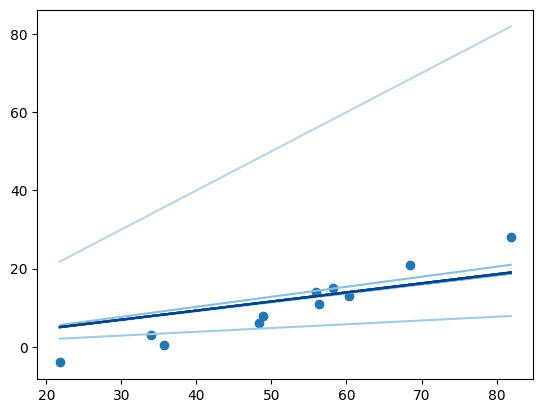

In [97]:
blues = plt.get_cmap('Blues')
x_ = np.linspace(float(t_u.min()), float(t_u.max()), 100)
plt.scatter(t_u, t_c)
for i, (w_, b_) in enumerate(zip(ws, bs)):
    y_opt = model(x_, w_, b_).numpy()
    plt.plot(x_, y_opt, color = blues(0.3 + 0.7 * float(i)/len(ws)))

## Analytical Derivatives

In [98]:
def dLossFn_dModel(y_pred, y_truth):
    return 2 * (y_pred - y_truth) / len(y_pred)
    
def dModel_dw(x, w, b):
    return x

def dModel_db(x, w, b):
    return 1.0

def a_grad(x, y_pred, y_truth, w, b):
    dL_dM = dLossFn_dModel(y_pred, y_truth)
    dL_dw = dL_dM * dModel_dw(x, w, b)
    dL_db = dL_dM * dModel_db(x, w, b)
    return torch.stack([dL_dw.sum(), dL_db.sum()])

### Down the (analytical) Gradient

In [99]:
def training_loop(n_epochs, learning_rate, params, x, y_truth):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        y_pred = model(x, w, b)
        loss = loss_fn(y_pred, y_truth)
        grad = a_grad(x, y_pred, y_truth, w, b)
        
        params = params - learning_rate * grad
        
        print(f"Epoch {epoch:2}, Loss {loss:.6}, Grad {grad}")
    return params

In [100]:
training_loop(
    n_epochs = 10,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    x = t_u,
    y_truth = t_c
)

Epoch  1, Loss 1763.88, Grad tensor([4517.2964,   82.6000])
Epoch  2, Loss 323.091, Grad tensor([1859.5493,   35.7843])
Epoch  3, Loss 78.9296, Grad tensor([765.4666,  16.5122])
Epoch  4, Loss 37.5528, Grad tensor([315.0790,   8.5787])
Epoch  5, Loss 30.5403, Grad tensor([129.6733,   5.3127])
Epoch  6, Loss 29.3512, Grad tensor([53.3495,  3.9682])
Epoch  7, Loss 29.1489, Grad tensor([21.9304,  3.4148])
Epoch  8, Loss 29.1138, Grad tensor([8.9964, 3.1869])
Epoch  9, Loss 29.1071, Grad tensor([3.6721, 3.0930])
Epoch 10, Loss 29.1052, Grad tensor([1.4803, 3.0544])


tensor([ 0.2324, -0.0166])

**TODO: contiune**

## Autograd

In [101]:
def a_training_loop(n_epochs, learning_rate, params, x, y_truth):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y_truth)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss {loss}")
            print(f"  Params: {params}")
            print(f"  Grads:  {params.grad}")
    return params

Training works but requires scaling the features to bring the gradients wrt. `w` and `b` into the same order of magnitude.

In [102]:
t_un = 0.1 * t_u
params = torch.tensor([1.0, 0.0], requires_grad=True)
# a_training_loop(n_epochs = 5000,
a_training_loop(n_epochs = 3000,
              learning_rate = 1e-2,
              params = params,
              x = t_un,
              y_truth = t_c
)

Epoch 500, Loss 7.860115051269531
  Params: tensor([ 4.0443, -9.8133], requires_grad=True)
  Grads:  tensor([-0.2252,  1.2748])
Epoch 1000, Loss 3.828537940979004
  Params: tensor([  4.8021, -14.1031], requires_grad=True)
  Grads:  tensor([-0.0962,  0.5448])
Epoch 1500, Loss 3.092191219329834
  Params: tensor([  5.1260, -15.9365], requires_grad=True)
  Grads:  tensor([-0.0411,  0.2328])
Epoch 2000, Loss 2.957697868347168
  Params: tensor([  5.2644, -16.7200], requires_grad=True)
  Grads:  tensor([-0.0176,  0.0995])
Epoch 2500, Loss 2.933133840560913
  Params: tensor([  5.3236, -17.0549], requires_grad=True)
  Grads:  tensor([-0.0075,  0.0425])
Epoch 3000, Loss 2.9286484718322754
  Params: tensor([  5.3489, -17.1980], requires_grad=True)
  Grads:  tensor([-0.0032,  0.0182])


tensor([  5.3489, -17.1980], requires_grad=True)

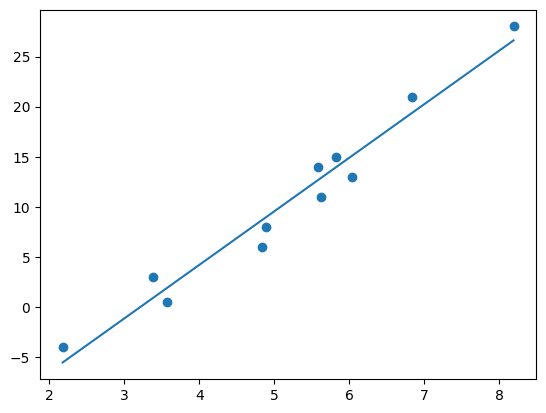

In [103]:

x_ = np.linspace(t_un.numpy().min(), t_un.numpy().max(), 10)
plt.scatter(t_un, t_c)
with torch.no_grad():
    plt.plot(x_, model(x_, *(params.numpy())))

## Optimizers

In [104]:
import torch.optim as optim

In [105]:
def ao_training_loop(n_epochs, optimizer, params, x, y_truth):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y_truth)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch:2}, Loss {loss:.4}")

    return params


In [106]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

learning_rate = 1e-2  # <- training diverges, when one order of magnitude larger
optimizer = optim.SGD([params], lr=learning_rate)

x = t_u  # <- training diverges, when not scaled
x = t_un
y_truth = t_c

ao_training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    params=params,
    x=t_un,
    y_truth=t_c)


Epoch 500, Loss 7.86
Epoch 1000, Loss 3.829
Epoch 1500, Loss 3.092
Epoch 2000, Loss 2.958
Epoch 2500, Loss 2.933
Epoch 3000, Loss 2.929


tensor([  5.3489, -17.1980], requires_grad=True)

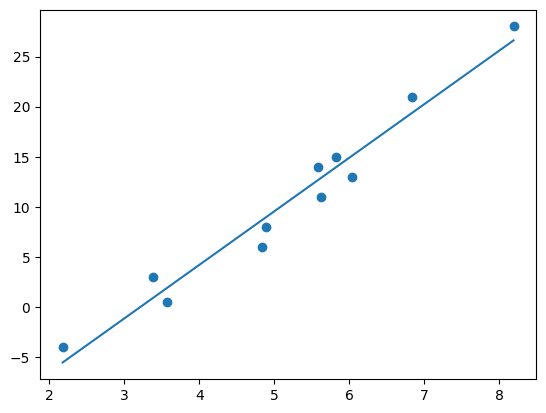

In [107]:
x = np.linspace(t_un.numpy().min(), t_un.numpy().max(), 10)
plt.scatter(t_un, t_c)
with torch.no_grad():
    plt.plot(x_, model(x_, *(params.numpy())))

Using the **Adam** optimizer, which is said to be more robust. And, indeed, in this toy example it holds up.

In [108]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

learning_rate = 1e-1  # <- an order of magnitude larger then SGD above, still converges
optimizer = optim.Adam([params], lr=learning_rate)

x = t_u  # <- unscaled, still converges
y_truth = t_c

ao_training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    params=params,
    x=t_un,
    y_truth=t_c)


Epoch 500, Loss 2.962
Epoch 1000, Loss 2.928


tensor([  5.3676, -17.3044], requires_grad=True)

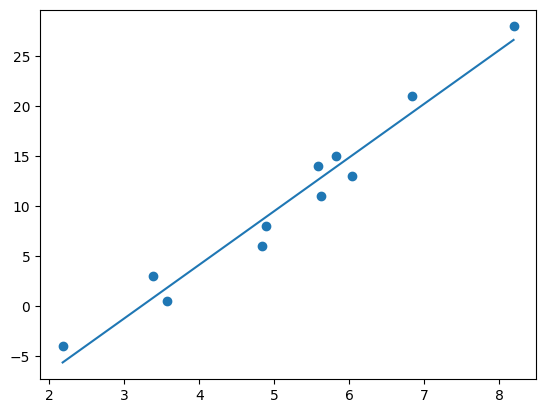

In [109]:

x = np.linspace(t_un.numpy().min(), t_un.numpy().max(), 10)
plt.scatter(t_un, t_c)
with torch.no_grad():
    plt.plot(x_, model(x_, *(params.numpy())))